In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
import os
import platform
%matplotlib inline

In [26]:
class SoftmaxClassifier:
    
    def __init__(self,dictionary):
        self.X_train = list()
        self.y_train = list() 
        self.X_test  = list()
        self.y_test  = list()
        self.X_train_x = list()
        self.y_train_x = list()
        self.data_dir = dictionary['data_dir']
        self.lr = dictionary['learning_rate']
        self.mmt = dictionary['momentum']
        self.initial_lr = dictionary['learning_rate']
        self.num_iters = dictionary['num_iters']
        self.batch_size = dictionary['batch_size']
        self.save_weights = dictionary['save_weights']
        self.reg = 1e-3
        self.vel = 0
        
        if dictionary['load_weights'] == 1:
            with open('./save/weights' , 'rb') as f:
                self.Weight = pickle.load(f)
        else:
            # Random initialization of W
            C, D = 10, 3073  # C :number of classes, D: dimension of each flattened image + one bias
            self.Weight = np.random.randn(C, D) * 0.01

    def load_pickle(self, f):
        version = platform.python_version_tuple()
        if version[0] == '2':
            return  pickle.load(f)
        elif version[0] == '3':
            return  pickle.load(f, encoding='latin1')
        raise ValueError("invalid python version: {}".format(version))

    def load_CIFAR_batch(self, filename):
        with open(filename, 'rb') as f:
            datadict = self.load_pickle(f)
            X = datadict['data']
            Y = datadict['labels']
            X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
            Y = np.array(Y)
            return X, Y

    def load_CIFAR10(self, PATH):
        xs = []
        ys = []
        for t in range(1,6):
            f = os.path.join(PATH, 'data_batch_%d' % (t, ))
            X, Y = self.load_CIFAR_batch(f)
            xs.append(X)
            ys.append(Y)    
        Xtr = np.concatenate(xs)
        Ytr = np.concatenate(ys)
        del X, Y
        Xte, Yte = self.load_CIFAR_batch(os.path.join(PATH, 'test_batch'))
        return Xtr/255.0, Ytr, Xte/255.0, Yte
    
    def loadData(self):
        
        self.X_train, self.y_train, self.X_test, self.y_test = self.load_CIFAR10(self.data_dir)
        
        print('Shape of Training: ', self.X_train.shape)
        print('Shape of Training labels : ', self.y_train.shape)
        print('Shape of Test: ', self.X_test.shape)
        print('Shape of Test labels: ', self.y_test.shape)
        
    def visualize(self):
        classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        classes_total = len(classes)
        samples_per_class = 7
        for y, cls in enumerate(classes):
            idxs = np.flatnonzero(self.y_train == y)
            idxs = np.random.choice(idxs, samples_per_class, replace=False)
            for i, indx in enumerate(idxs):
                plt_indx = i * classes_total + y + 1
                plt.subplot(samples_per_class, classes_total, plt_indx)
                plt.imshow(self.X_train[indx])
                plt.axis('off')
                if i == 0:
                    plt.title(cls)
        plt.show()
    
    def conver_to_onehot(self, label):
        
        OneHot = np.zeros((label.shape[0],10))
        for i in range(label.shape[0]):

            OneHot[i,label[i]] = 1

        return OneHot
    
    def getData(self):
        
        num_training = 50000
        mask = list(range(num_training))
        X_train = np.copy(self.X_train[mask])
        y_train = np.copy(self.y_train[mask])

        num_test = 10000
        mask = list(range(num_test))
        X_test = np.copy(self.X_test[mask])
        y_test = np.copy(self.y_test[mask])

        X_train = np.reshape(X_train, (X_train.shape[0], -1))
        X_test = np.reshape(X_test, (X_test.shape[0], -1))
        
        y_train = self.conver_to_onehot(y_train)
        y_test = self.conver_to_onehot(y_test)
        
        return X_train, X_test, y_train, y_test

    def train(self, inputs, label):

        Num,_ = inputs.shape  
        chunk = int((Num/self.batch_size)+0.5)
        loss_record = [float('inf')]
        count = 0
        for it in range(self.num_iters):
            
            indices = np.random.choice(Num, Num, replace=False)
            idx=[]
            k = 0
            loss = 0
            for m in range(chunk):
                idx.append(indices[k:k+self.batch_size])
                k = k + self.batch_size
            
            for b in range(chunk):
                
                batch_input = inputs[idx[b], :]
                batch_label = label[idx[b]]

                one = np.ones((batch_input.shape[0], 1))
                batch_input = np.append(one, batch_input, axis=1)

                batch_loss, grad = self.loss_calculation(batch_input, batch_label, self.reg)
                loss = loss + batch_loss

                self.vel = (self.vel *self.mmt) + (self.lr * grad)
                self.Weight -= self.vel
        
                
                
            loss_record.append(loss)
            print('Iteration = %d, loss =%f'% (it, loss))
            
            if self.save_weights == 1 and (it+1)%100 ==0:
                with open('./save/weights', 'wb') as files:
                    pickle.dump(self.Weight, files)
            
            #Early stoping criteria
            if abs(loss_record[-2] - loss_record[-1]) < 1e-6:
                count = count + 1
            else:
                count = 0
                
            if count == 10:
                break
            
        return loss_record

    def predict(self, inputs):
       
        one = np.ones((inputs.shape[0], 1))
        inputs = np.append(one, inputs, axis=1)
        label_onehot = self.Weight.dot(inputs.T)
        label_predicted = np.argmax(label_onehot, axis=0)
        return label_predicted
    
    def test(self, inputs, label):
        
        pred = self.predict(inputs)
        
        count = 0
        for i in range(len(pred)):
            
            if np.argmax(label[i]) == pred[i]:
                count += 1
        
        print('Correct calssification = %d/%d, Accuracy = %f'% (count, len(pred), count/len(pred)))      

    def loss_calculation(self, inputs, label, reg):
    
        dot = self.Weight.dot(inputs.T) 
        prob = np.exp(dot) / np.sum(np.exp(dot), axis=0)  
        loss = -1 / len(label) * np.sum(np.log(prob.T[range(len(label)),label.argmax(axis=1)]))  
        prob.T[range(len(label)),label.argmax(axis=1)] -= 1
        derivative = 1 / len(label) * prob.dot(inputs)
        return loss, derivative
   

In [27]:
dictionary = {'learning_rate' : 1e-3,
              'momentum': 0.05,
             'num_iters' : 100,
              'batch_size': 50000,
              'save_weights': 0,
              'load_weights': 0,
             'data_dir' : './data/cifar-10-batches-py'}

In [28]:
classifier = SoftmaxClassifier(dictionary)

Shape of Training:  (50000, 32, 32, 3)
Shape of Training labels :  (50000,)
Shape of Test:  (10000, 32, 32, 3)
Shape of Test labels:  (10000,)


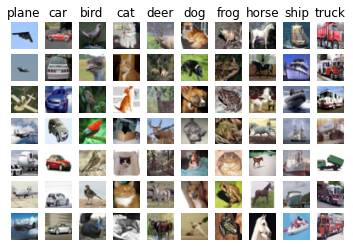

In [29]:
classifier.loadData()
classifier.visualize()

In [30]:
X_train, X_test, y_train, y_test = classifier.getData()

In [ ]:
loss = classifier.train(X_train, y_train)

Iteration = 0, loss =2.334724
Iteration = 1, loss =2.329976
Iteration = 2, loss =2.325539
Iteration = 3, loss =2.321601
Iteration = 4, loss =2.318103
Iteration = 5, loss =2.314984
Iteration = 6, loss =2.312193
Iteration = 7, loss =2.309682
Iteration = 8, loss =2.307413
Iteration = 9, loss =2.305352
Iteration = 10, loss =2.303470
Iteration = 11, loss =2.301740
Iteration = 12, loss =2.300142
Iteration = 13, loss =2.298658
Iteration = 14, loss =2.297270
Iteration = 15, loss =2.295965
Iteration = 16, loss =2.294732
Iteration = 17, loss =2.293561
Iteration = 18, loss =2.292443
Iteration = 19, loss =2.291370
Iteration = 20, loss =2.290336
Iteration = 21, loss =2.289337
Iteration = 22, loss =2.288367
Iteration = 23, loss =2.287422
Iteration = 24, loss =2.286500
Iteration = 25, loss =2.285596
Iteration = 26, loss =2.284710
Iteration = 27, loss =2.283838
Iteration = 28, loss =2.282979
Iteration = 29, loss =2.282131
Iteration = 30, loss =2.281294
Iteration = 31, loss =2.280466
Iteration = 32, lo

In [ ]:
plt.plot(loss)

In [16]:
classifier.test(X_test, y_test)

Correct calssification = 6/10, Accuracy = 0.600000
